## Imports

In [ ]:
# !git clone https://github.com/Holstrup/MetricLearning
# import os
# os.chdir("MetricLearning/MetricLearning")
# !git pull

In [ ]:
import sklearn.metrics as sk_metrics
import sklearn.decomposition as sk_decomp
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import Model
import Plots
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import knnClassifier
from sklearn.model_selection import KFold
from scipy.special import softmax
import plot_confusion_matrix as plots
import random
from knnClassifier import calc_mode

# We ignore divisions by 0. We will do that in the chi square distance, but we don't care. 
np.seterr(divide='ignore', invalid='ignore')

## Hyperparameters

Underneath you can define the hyperparameters, l, mu and K.
* $l$ is the margin parameter
* $\mu$ is a trade-off parameter between the push and pull in the loss function
* $K$ is the number of target neighbors 
* $D$ is the dimensionality of our data. We choose that arbitrarily
* $L$ is the linear transformation

L is set to be a diagonal matrix of ones to begin with. However, it would be interesting to experiement with other initial L matrices, since the problem is non-convex. We could also try to implement the constrained non-convex version of LMNN.

In [ ]:
mu = 0.5
K = 5
D = 10
L = np.eye(D, dtype=float)
alpha = 0.001

## Functions

This block defines two functions that we will use to compute the distances. The first function calculates the distance given two points xi and xj. The second function calculates the distance between some point xi and all the other points X, through the L space. This is very important to note. 

* $chi-square-distance(xi, xj)$ corresponds to (3) in the [Non-linear metric learning paper](http://www.cs.cornell.edu/~kilian/papers/chilmnn.pdf)
* $distance(xi, X)$ is an extension to $chi-square-distance(xi, xj)$, namely finding the chi square distance from one point xi, to all the other points

In [ ]:
def chi_square_distance(xi, xj):
    """
    Chi square distance

    :param xi: Embedding       (1, D)
    :param xj: Target Neighbor (1, D)
    :return: Distance
    """
    return 1 / 2 * np.nansum(np.square(xi - xj) / (xi + xj))

def distance(xi, X, L):
    """
    Chi square distance from one point xi, to all other points
    
    :param xi: Embedding       (1, D)
    :param X: Data             (N, D)
    :return: Distances         (1, N)
    
    """
    N, K = np.shape(X)
    Distances = np.zeros(N)
    for i in range(N):
        Distances[i] = chi_square_distance(L @ xi, L @ X[i, :])
    return Distances

These next functions are calculating the target neighbors and the imposters. Read through the comments, and it should make sense how it is done. One little note: In the target neighbours function, we find the distance through the L space. This is meant as the initial L space. We only find these target neighbours once, and should therefore not update what target neighbors a specific point xi has. 

In [ ]:
def find_target_neighbors(X, Y, L):
    """
    Find target neighbours for all points
    
    :param X: Data Matrix      (N, D)
    :param Y: Labels           (1, N)
    :return: TN_lookup_table   (N, K)
    :return: TN_distance_table (N, K)
    """
    
    global TN_lookup_table
    global TN_distance_table
    
    N, _ = np.shape(X)
    TN_lookup_table = np.zeros((N, K))
    TN_distance_table = np.zeros((N, K))

    for i in range(N):
        xi = X[i,:]
        yi = Y[i]
        
        # Find distance from xi to all other points
        TN_Distances = distance(xi, X, L)
        TN_Indicies = np.argsort(TN_Distances)
        j = k = 0
        
        #Loop to add indicies of target neighbours to lookup table
        while j < K:
            # if yi and target neighbour have the same label AND it is not the same point
            if Y[TN_Indicies[k]] == yi and TN_Indicies[k] != i:
                # Add to lookup table and distance table
                TN_lookup_table[i, j] = TN_Indicies[k]
                TN_distance_table[i, j] = TN_Distances[TN_Indicies[k]]
                j += 1
            k += 1
    TN_lookup_table = TN_lookup_table.astype(int)
    return TN_lookup_table, TN_distance_table

#Check if the impostor is within the margin of the target neighbor + marginal distance l
def check(L, xi, xj, xk):
    return (chi_square_distance(L @ xi, L @ xj) + l >= chi_square_distance(L @ xi, L @ xk)) 

## LMNN Functions

These next functions, are made from looking at this [Chi square Metric Learning for Nearest Neighbor Classification and Its Analysis paper](https://projet.liris.cnrs.fr/imagine/pub/proceedings/ICPR-2012/media/files/1795.pdf). Specifically, if you scroll to the last page you can see the equations that are implemented below. Here are some notes, that helps when you read it: 
* $L_{\alpha, \beta}$ refers to the alpha'th row and the beta'th column in the L matrix. Same goes for all the other places there is subscript. 
* $\psi_{i, j, \alpha}$ in this paper is the same as $t_{i,j}$ in the Yang paper
* In this paper they refer to imposters with the letter l (as opposed to k in the other papers)
* $\xi_{i, j, l}$ I interpret as a check that the point $x_{l}$ is actually an imposter. That should always be the case since, we calculate the imposters this way in the imposters function.

* $gradient-function$ is the main function that deals with computing the gradient
* $gradient-element$ sustains $gradient-function$ and corresponds to (26) and (27) in the above stated [paper](https://projet.liris.cnrs.fr/imagine/pub/proceedings/ICPR-2012/media/files/1795.pdf)
* $outer-loss$ corresponds to (11) - for target neighbors 
* $inner-loss-function$ corresponds to (12) - for impostors

* $tau-function$ ($\Psi$ in the text) corresponds to (25) in the above stated [paper](https://projet.liris.cnrs.fr/imagine/pub/proceedings/ICPR-2012/media/files/1795.pdf) 

In [ ]:
#Tau Function
def tau_function(X_Matrix, L_Matrix, i, j, alpha):
    _, D = np.shape(L_Matrix)
    numerator = 0
    denominator = 0
    for k in range(D):
        numerator +=   L_Matrix[alpha, k] * (X_Matrix[i, k] - X_Matrix[j, k])
        denominator += L_Matrix[alpha, k] * (X_Matrix[i, k] + X_Matrix[j, k])
    return numerator / denominator

In [ ]:
def gradient_and_loss_function(X, Y, L_Matrix):
    R, D = np.shape(L_Matrix)
    gradient_matrix = np.zeros((R,D))
    loss = 0
    for alpha in range(R):
        for beta in range(D):
            if( (alpha == D-1) and (beta == D-1) ):
                gradient_matrix[alpha, beta], loss = gradient_and_loss_element(X, Y, L_Matrix, alpha, beta, True)
            else:
                gradient_matrix[alpha, beta], _ = gradient_and_loss_element(X, Y, L_Matrix, alpha, beta, True)
    return gradient_matrix, loss
            
def gradient_and_loss_element(X_Matrix, Y, L_Matrix, alpha, beta, return_loss):
    N, _ = np.shape(X_Matrix)
    gradient = 0
    outer_sum = 0
    Inner_sum = 0
    loss = 0
    for i in range(N):
        Pull = 0
        for j in TN_lookup_table[i, :]:
            tauij = tau_function(X_Matrix, L_Matrix, i, j, alpha)
            Lij = 2 * tauij * (X_Matrix[i, beta] - X_Matrix[j, beta]) - (tauij**2) * (X_Matrix[i, beta] + X_Matrix[j, beta])
            outer_sum += Lij
            for k in range(N):
                # We need to update the distance to our target neighbours and compute the max distance
                if (check(L, X_Matrix[i],  X_Matrix[j],  X_Matrix[k]) and (Y[i] != Y[k])):
                    #print("   ", i, " has imposter ", k)
                    tauik = tau_function(X_Matrix, L_Matrix, i, k, alpha)
                    Lik = 2 * tauik * (X_Matrix[i, beta] - X_Matrix[k, beta]) - (tauik**2) * (X_Matrix[i, beta] + X_Matrix[k, beta])
                    Inner_sum += Lij - Lik
            # Calculate loss
            if(return_loss):
                loss += (1 - mu) * pullLoss(X_Matrix, L_Matrix, i, j) + mu * pushLoss(X_Matrix, Y, L_Matrix, i, j)
            
    gradient = (1 - mu) * outer_sum + mu * Inner_sum
    return gradient, loss

#Loss for pull
def pullLoss(X_Matrix, L_Matrix, i, j):
    return chi_square_distance(L_Matrix @ X_Matrix[i], L_Matrix @ X_Matrix[j])
            
#Loss for push
def pushLoss(X_Matrix, Y, L_Matrix, i, j):
    loss = 0
    N, _ = np.shape(X_Matrix)
    for k in range(N):
        if (check(L_Matrix, X_Matrix[i],  X_Matrix[j],  X_Matrix[k]) and (Y[i] != Y[k])):
            loss += max(0, l + chi_square_distance(L_Matrix @ X_Matrix[i], L_Matrix @ X_Matrix[j]) - chi_square_distance(L_Matrix @ X_Matrix[i], L_Matrix @ X_Matrix[k]))
    return loss

## Separate implementation of the loss function, gradient for pulling and gradient for pushing

### Implementation of the loss function

In [ ]:
def loss_function(X, Y, L_Matrix):
    loss = 0
    D, D = np.shape(L_Matrix)
    for alpha in range(D):
        for beta in range(D):
            loss += loss_element(X, Y, L_Matrix, alpha, beta)
    return loss

def loss_function2(X, Y, L_Matrix):
    loss = 0
    N, D = np.shape(X)
    for i in range(N):
        for j in TN_lookup_table[i]:
            loss += (1-mu)*chi_square_distance(L_Matrix @ X[i], L_Matrix @ X[j])
            for k in range(N):
                if (check(L_Matrix, X[i],  X[j],  X[k]) and (Y[i] != Y[k])):
                    loss += mu*(l + chi_square_distance(L_Matrix @ X[i], L_Matrix @ X[j]) - chi_square_distance(L_Matrix @ X[i], L_Matrix @ X[k]))
    return loss

def loss_element(X, Y, L_Matrix, alpha, beta):
    loss = 0
    global mu
    N, _ = np.shape(X)
    
    for i in range(N):
        Pull = 0
        for j in TN_lookup_table[i, :]:
            # Calculate loss
            loss += (1 - mu) * pull_loss(X, L_Matrix, i, j) + mu * push_loss(X, Y, L_Matrix, i, j)
    return loss

#Loss for pull
def pull_loss(X_Matrix, L_Matrix, i, j):
    return chi_square_distance(L_Matrix @ X_Matrix[i], L_Matrix @ X_Matrix[j])

#Loss for push
def push_loss(X_Matrix, Y, L_Matrix, i, j):
    loss = 0
    N, _ = np.shape(X_Matrix)
    for k in range(N):
        if (check(L_Matrix, X_Matrix[i],  X_Matrix[j],  X_Matrix[k]) and (Y[i] != Y[k])):
            loss += max(0, l + chi_square_distance(L_Matrix @ X_Matrix[i], L_Matrix @ X_Matrix[j]) - chi_square_distance(L_Matrix @ X_Matrix[i], L_Matrix @ X_Matrix[k]))
    return loss

### Implementation of the gradient for pulling and pushing

* $Pull(XMatrix, LMatrix)$ corresponds to (26)
* $Push(XMatrix, LMatrix, Y)$ corresponds to (27)

In [ ]:
### PULL FUNCTIONS
def Pull(X_Matrix, L_Matrix):
    D, D = np.shape(L_Matrix)
    gradient_matrix = np.zeros((D,D))
    for alpha in range(D):
        for beta in range(D):
            gradient_matrix[alpha, beta] = Pull_matrix_element(X_Matrix, L_Matrix, alpha, beta)
    return gradient_matrix

def Pull_matrix_element(X_Matrix, L_Matrix, alpha, beta):
    N, D = np.shape(X_Matrix)
    gradient = 0
    for i in range(N):
        for j in TN_lookup_table[i, :]:
            tau = tau_function(X_Matrix, L_Matrix, i, j, alpha)
            gradient += 2 * tau * (X_Matrix[i, beta] - X_Matrix[j, beta]) - (tau**2) * (X_Matrix[i, beta] + X_Matrix[j, beta])
    return gradient

In [ ]:
### PUSH FUNCTIONS
def Push(X_Matrix, L_Matrix, Y):
    D, D = np.shape(L_Matrix)
    gradient_matrix = np.zeros((D,D))
    for alpha in range(D):
        for beta in range(D):
            gradient_matrix[alpha, beta] = Push_matrix_element(X_Matrix, L_Matrix, Y, alpha, beta)
    return gradient_matrix

def Push_matrix_element(X_Matrix, L_Matrix, Y, alpha, beta):
    N, D = np.shape(X_Matrix)
    gradient = 0
    for i in range(N):
        for j in TN_lookup_table[i, :]:
            for k in range(N):
                if (check(L, X_Matrix[i],  X_Matrix[j],  X_Matrix[k]) and (Y[i] != Y[k])):
                    tauij = tau_function(X_Matrix, L_Matrix, i, j, alpha)
                    tauik = tau_function(X_Matrix, L_Matrix, i, k, alpha)
                    Lij = 2 * tauij * (X_Matrix[i, beta] - X_Matrix[j, beta])          - (tauij**2) * (X_Matrix[i, beta] + X_Matrix[j, beta])
                    Lik = 2 * tauik * (X_Matrix[i, beta] - X_Matrix[k, beta]) - (tauik**2) * (X_Matrix[i, beta] + X_Matrix[k, beta])
                    gradient += Lij - Lik
    return gradient

The update for the gradient is done based on the predefined learning rate.
The gradient should not be negative and its values should sum up to 1. Thus, we have made use of the softmax function for updating the gradient.

In [ ]:
def update_step(G):
    """
    Update L
    
    :param G: Computed gradient for a given iteration
    """
    global L
    new_L = L - alpha * G
    L = softmax(new_L, axis = 0)

## Artificial Data

In [ ]:
# Based on post from Thomas Boggs (http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/)
_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])

def plot_simplex_3d(X, labels, centre, ind):
    if len(X) != len(labels):
        print("Dimensions don't match...")
        return 0
    
    C1 = (labels == 0)
    C2 = (labels == 1)
    C3 = (labels == 2)
    
    MS = 0
    if centre:
        MS = 2
    else:
        MS = 8
    
    X = X.dot(_corners)  #This is what converts the original points onto the simplex (it projects on it, through dot product)
    plt.plot(X[C1, 0], X[C1, 1], 'k.', ms=MS, c = "red")
    plt.plot(X[C2, 0], X[C2, 1], 'k.', ms=MS, c = "blue")
    plt.plot(X[C3, 0], X[C3, 1], 'k.', ms=MS, c = "green")

    if(ind >= 0):
        plt.plot(X[ind, 0], X[ind, 1], '*', ms=MS, c = "black")
    plt.axis('equal')
    if centre:
        plt.xlim(0.3, 0.7)
        plt.ylim(0.33, 0.34)
    else:
        plt.xlim(0, 1)
        plt.ylim(0, 0.75**0.5)
    
    plt.axis('off')
    plt.triplot(_triangle, linewidth=1)
    plt.show()
    
def plot_simplex_2d(X, labels):
    C1 = (labels == 0)
    C2 = (labels == 1)
    C3 = (labels == 2)
    
    plt.plot(X[C1, 0], X[C1, 1], 'k.', ms=8, c = "red")
    plt.plot(X[C2, 0], X[C2, 1], 'k.', ms=8, c = "blue")
    plt.plot(X[C3, 0], X[C3, 1], 'k.', ms=8, c = "green")
    plt.xlim(np.min(X[:,0]) - 0.05, np.max(X[:,0]) + 0.05)
    plt.ylim(np.min(X[:,1]) - 0.05, np.max(X[:,1]) + 0.05)
    plt.plot(np.array([0, 1]), np.array([1, 0]), ':')
    plt.show()

In [ ]:
size = 150

pts=np.random.dirichlet([.5,.5,.5], size)
C1 = pts[:,0] > 0.4
C2 = pts[:,1] > 0.4
C3 = np.logical_and(np.logical_not(C1), np.logical_not(C2))

## To create some noise we make 12 of the C1 observations the other classes.
c1imposter = np.where(np.logical_and(pts[:,0] < 0.65, C1) )[0]
c1remove = c1imposter[random.sample(range(len(c1imposter)), int(len(c1imposter)/2))]
C1[c1remove] = False
C3[c1remove] = True

c2imposter = np.where(np.logical_and(pts[:,1] < 0.65, C2) )[0]
c2remove = c2imposter[random.sample(range(len(c2imposter)), int(len(c2imposter)/2))]
C2[c2remove] = False
C3[c2remove] = True

label = np.zeros(len(pts))
label[C1] = 0
label[C2] = 1
label[C3] = 2
X_train, X_test, y_train, y_test = train_test_split(pts, label, test_size=0.2, random_state=0)
N, D = X_train.shape

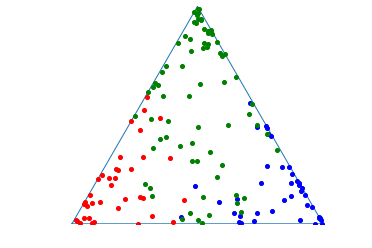

In [232]:
L = np.eye(D)
TN_lookup_table, TN_distance_table = find_target_neighbors(X_train, y_train, L)
C1train = (y_train == 0)
C2train = (y_train == 1)
C3train = (y_train == 2)

plot_simplex_3d(pts, label, False, -1)

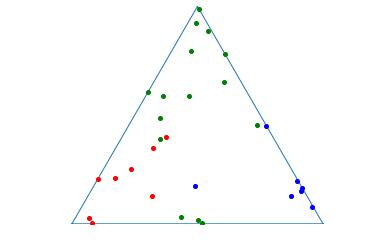

In [21]:
plot_simplex_3d(X_test, y_test, False, -1)

Learning rate (alpha):  0.1
 Margin (l):  0.005
 Trade-off (mu):  0.2
Accuracy =  0.8333333333333334
    Transformation matrix: 
 [[9.99909208e-01 4.53958078e-05 4.53958078e-05]
 [4.53958078e-05 9.99909208e-01 4.53958078e-05]
 [4.53958078e-05 4.53958078e-05 9.99909208e-01]]
    Loss:  13.669109056127533




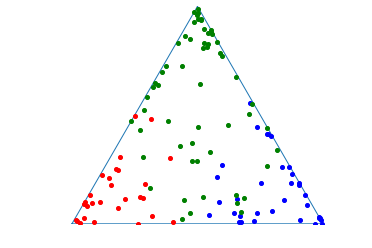

Accuracy =  0.9
    Transformation matrix: 
 [[1.30919014e-03 8.09658054e-01 5.42191444e-01]
 [5.56680056e-01 2.49309742e-04 4.55896321e-01]
 [4.42010754e-01 1.90092636e-01 1.91223482e-03]]
    Loss:  5.971267934122833




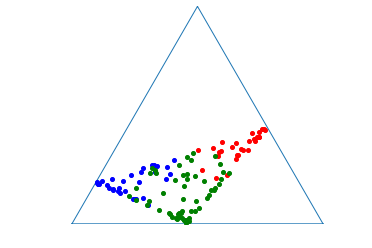

Accuracy =  0.7666666666666667
    Transformation matrix: 
 [[0.9139018  0.08308845 0.1934391 ]
 [0.04175561 0.8034859  0.27698302]
 [0.04434259 0.11342565 0.52957787]]
    Loss:  5.75078127351526




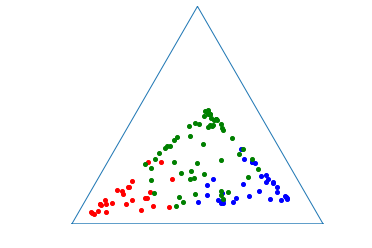

Accuracy =  0.8666666666666667
    Transformation matrix: 
 [[0.13073245 0.5866022  0.4722459 ]
 [0.51780621 0.23101997 0.27466537]
 [0.35146134 0.18237783 0.25308873]]
    Loss:  7.482017407926246




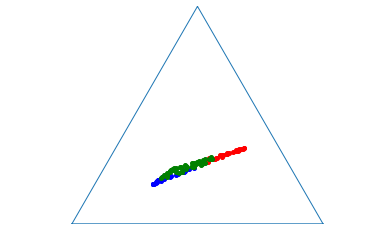

Accuracy =  0.8
    Transformation matrix: 
 [[1.49160815e-01 3.78715274e-01 4.04952174e-04]
 [8.01197714e-01 6.21120928e-01 2.52602999e-05]
 [4.96414712e-02 1.63797512e-04 9.99569788e-01]]
    Loss:  12.832042576576226




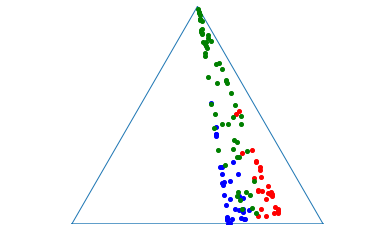

Learning rate (alpha):  0.1
 Margin (l):  0.030000000000000002
 Trade-off (mu):  0.2
Accuracy =  0.8
    Transformation matrix: 
 [[9.99909208e-01 4.53958078e-05 4.53958078e-05]
 [4.53958078e-05 9.99909208e-01 4.53958078e-05]
 [4.53958078e-05 4.53958078e-05 9.99909208e-01]]
    Loss:  20.913568484244454




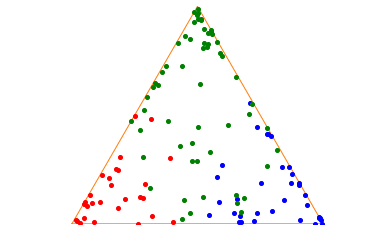

Accuracy =  0.9
    Transformation matrix: 
 [[2.51376400e-03 8.83998269e-01 5.95699375e-01]
 [5.09815362e-01 4.76720279e-04 4.01275400e-01]
 [4.87670874e-01 1.15525010e-01 3.02522483e-03]]
    Loss:  22.58406883052338




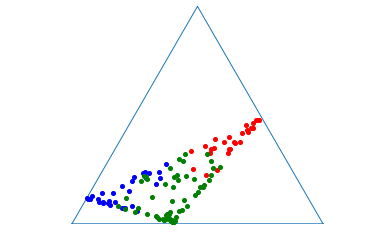

Accuracy =  0.7666666666666667
    Transformation matrix: 
 [[5.43662957e-01 3.65118856e-01 2.97928413e-02]
 [6.01480798e-02 4.15224839e-03 9.69967971e-01]
 [3.96188963e-01 6.30728895e-01 2.39187249e-04]]
    Loss:  45.49215071246564




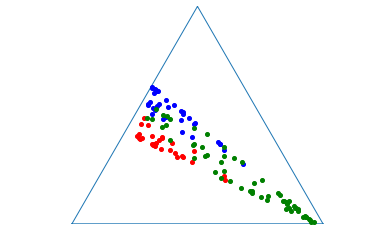

Accuracy =  0.9
    Transformation matrix: 
 [[9.99998091e-01 2.32826512e-15 4.17837522e-02]
 [1.90854261e-06 2.51860436e-07 9.79644426e-02]
 [6.28816636e-16 9.99999748e-01 8.60251805e-01]]
    Loss:  33.05510918848474




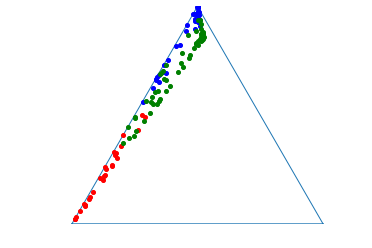

Accuracy =  0.7666666666666667
    Transformation matrix: 
 [[7.29163886e-02 5.05499671e-04 1.04700557e-07]
 [1.22513026e-05 1.37650512e-33 9.99999895e-01]
 [9.27071360e-01 9.99494500e-01 1.19762873e-12]]
    Loss:  49.41158060418145




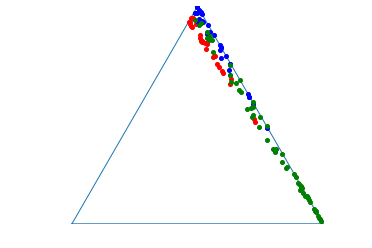

Learning rate (alpha):  0.1
 Margin (l):  0.055
 Trade-off (mu):  0.2
Accuracy =  0.8333333333333334
    Transformation matrix: 
 [[9.99909208e-01 4.53958078e-05 4.53958078e-05]
 [4.53958078e-05 9.99909208e-01 4.53958078e-05]
 [4.53958078e-05 4.53958078e-05 9.99909208e-01]]
    Loss:  31.94065343977634




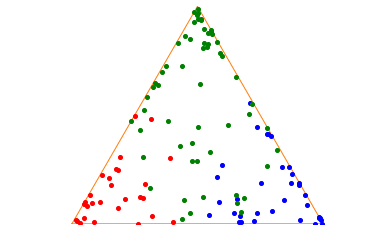

Accuracy =  0.8666666666666667
    Transformation matrix: 
 [[0.01544813 0.93625538 0.65063495]
 [0.54374136 0.00340277 0.33789325]
 [0.44081051 0.06034184 0.0114718 ]]
    Loss:  62.24643751017355




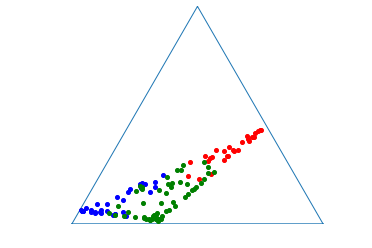

Accuracy =  0.8
    Transformation matrix: 
 [[1.08337025e-05 1.16090764e-01 9.18459924e-09]
 [1.06535492e-04 6.78146363e-17 9.99999991e-01]
 [9.99882631e-01 8.83909236e-01 1.37617436e-25]]
    Loss:  89.75263995830392




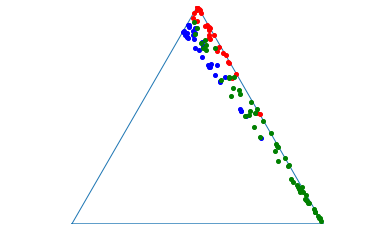

Accuracy =  0.8333333333333334
    Transformation matrix: 
 [[8.86269075e-83 1.00000000e+00 2.42390710e-12]
 [1.82807789e-03 1.10752524e-29 8.08063540e-01]
 [9.98171922e-01 6.71739843e-30 1.91936460e-01]]
    Loss:  31.469458581550082




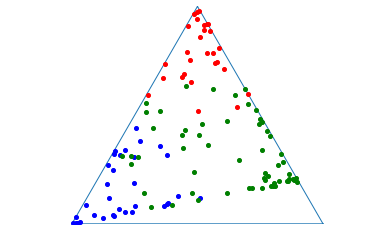

Accuracy =  0.7
    Transformation matrix: 
 [[0.90941051 0.10732483 0.94683938]
 [0.04896211 0.7926105  0.04278627]
 [0.04162738 0.10006467 0.01037435]]
    Loss:  130.58758534020046




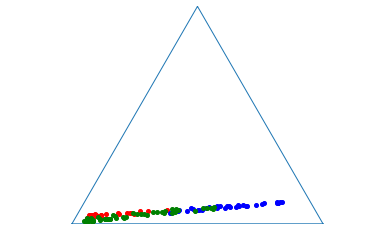

Learning rate (alpha):  0.1
 Margin (l):  0.08000000000000002
 Trade-off (mu):  0.2
Accuracy =  0.8
    Transformation matrix: 
 [[9.99909208e-01 4.53958078e-05 4.53958078e-05]
 [4.53958078e-05 9.99909208e-01 4.53958078e-05]
 [4.53958078e-05 4.53958078e-05 9.99909208e-01]]
    Loss:  47.09747312487392




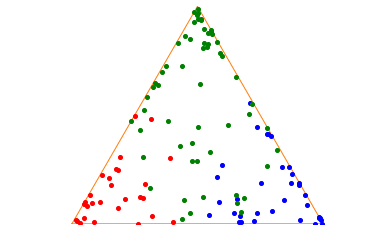

Accuracy =  0.8666666666666667
    Transformation matrix: 
 [[0.19965101 0.93672821 0.75605554]
 [0.39622857 0.04031809 0.17840077]
 [0.40412041 0.0229537  0.0655437 ]]
    Loss:  226.87747597695576




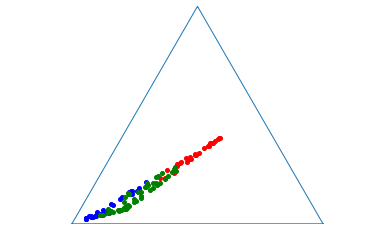

Accuracy =  0.8666666666666667
    Transformation matrix: 
 [[7.36690156e-25 1.00000000e+00 1.49432252e-23]
 [2.74361334e-08 2.74544475e-61 1.00000000e+00]
 [9.99999973e-01 4.43768070e-44 8.63229123e-33]]
    Loss:  47.1005743881071




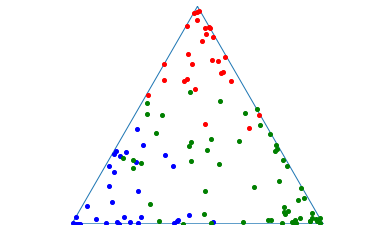

Accuracy =  0.8666666666666667
    Transformation matrix: 
 [[0.40097462 0.03089875 0.17718837]
 [0.40693793 0.01866148 0.06318497]
 [0.19208746 0.95043977 0.75962666]]
    Loss:  216.5070161535113




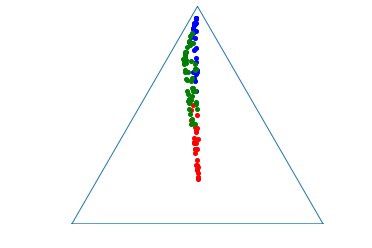

Accuracy =  0.8333333333333334
    Transformation matrix: 
 [[2.52028628e-08 4.66059833e-64 1.00000000e+00]
 [9.99999975e-01 4.16794998e-44 2.19510702e-33]
 [3.30954256e-23 1.00000000e+00 9.81640749e-25]]
    Loss:  47.10057440765613




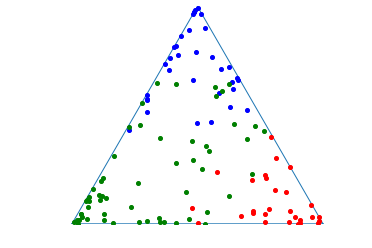

Learning rate (alpha):  0.1
 Margin (l):  0.005
 Trade-off (mu):  0.4
Accuracy =  0.8333333333333334
    Transformation matrix: 
 [[9.99909208e-01 4.53958078e-05 4.53958078e-05]
 [4.53958078e-05 9.99909208e-01 4.53958078e-05]
 [4.53958078e-05 4.53958078e-05 9.99909208e-01]]
    Loss:  16.34725798464175




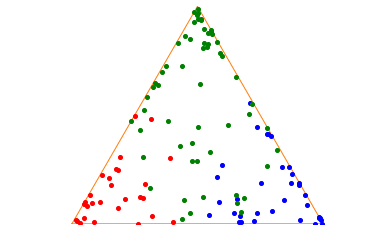

Accuracy =  0.9
    Transformation matrix: 
 [[0.00199125 0.49913913 0.4914439 ]
 [0.32280585 0.00077957 0.50512778]
 [0.6752029  0.5000813  0.00342832]]
    Loss:  7.7730808870656185




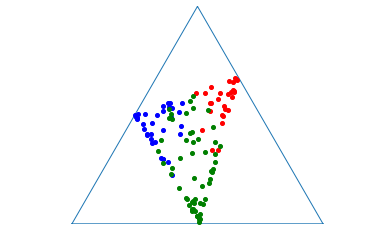

Accuracy =  0.7666666666666667
    Transformation matrix: 
 [[0.84329953 0.15038314 0.07355409]
 [0.09046052 0.72709371 0.09693282]
 [0.06623996 0.12252315 0.82951309]]
    Loss:  8.515993248130002




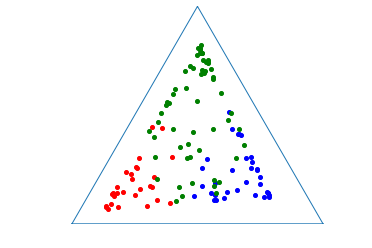

Accuracy =  0.7
    Transformation matrix: 
 [[0.10671493 0.3345802  0.57485353]
 [0.17165278 0.21862738 0.28804891]
 [0.7216323  0.44679241 0.13709756]]
    Loss:  19.467463731131282




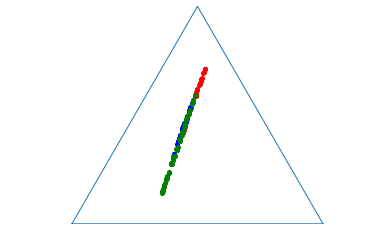

Accuracy =  0.8333333333333334
    Transformation matrix: 
 [[0.15390197 0.96226737 0.02283171]
 [0.71484005 0.0030856  0.40063069]
 [0.13125798 0.03464703 0.5765376 ]]
    Loss:  10.006385179130024




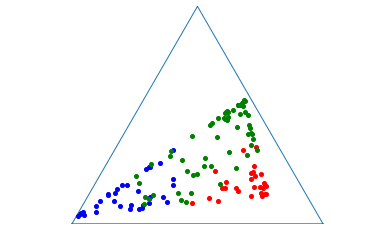

Learning rate (alpha):  0.1
 Margin (l):  0.030000000000000002
 Trade-off (mu):  0.4
Accuracy =  0.8
    Transformation matrix: 
 [[9.99909208e-01 4.53958078e-05 4.53958078e-05]
 [4.53958078e-05 9.99909208e-01 4.53958078e-05]
 [4.53958078e-05 4.53958078e-05 9.99909208e-01]]
    Loss:  30.836176840875563




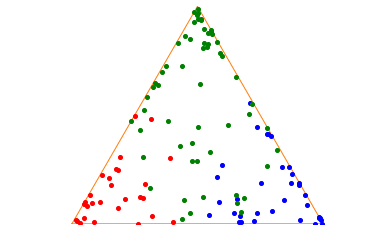

Accuracy =  0.7666666666666667
    Transformation matrix: 
 [[0.00667391 0.7603382  0.59732127]
 [0.24613157 0.0036424  0.39403901]
 [0.74719452 0.2360194  0.00863972]]
    Loss:  38.51061962551998




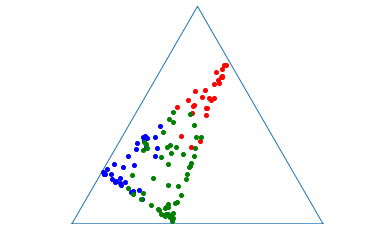

Accuracy =  0.8
    Transformation matrix: 
 [[2.77397256e-01 9.10011598e-01 2.70251356e-04]
 [6.12094765e-02 1.92530649e-08 9.99589660e-01]
 [6.61393267e-01 8.99883829e-02 1.40088530e-04]]
    Loss:  32.750224728262666




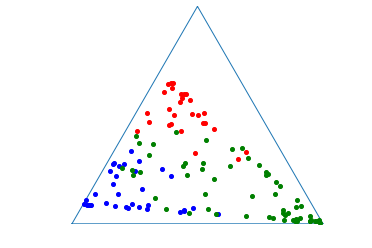

Accuracy =  0.8333333333333334
    Transformation matrix: 
 [[2.25812469e-03 1.26040047e-01 6.18080256e-01]
 [3.90098822e-01 8.73877811e-01 9.35027597e-02]
 [6.07643053e-01 8.21419647e-05 2.88416984e-01]]
    Loss:  33.64181583650398




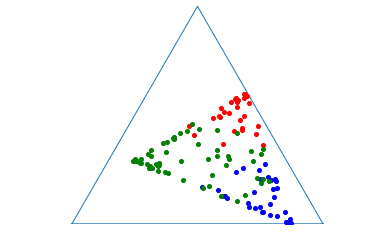

Accuracy =  0.8
    Transformation matrix: 
 [[0.00146003 0.05528701 0.87057295]
 [0.00653073 0.94340541 0.10164987]
 [0.99200924 0.00130758 0.02777718]]
    Loss:  29.344070708629907




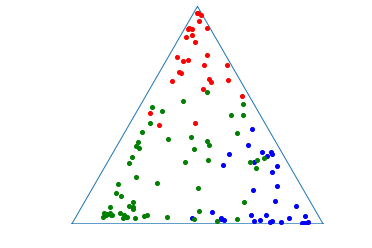

Learning rate (alpha):  0.1
 Margin (l):  0.055
 Trade-off (mu):  0.4
Accuracy =  0.8
    Transformation matrix: 
 [[9.99909208e-01 4.53958078e-05 4.53958078e-05]
 [4.53958078e-05 9.99909208e-01 4.53958078e-05]
 [4.53958078e-05 4.53958078e-05 9.99909208e-01]]
    Loss:  52.89034675193929




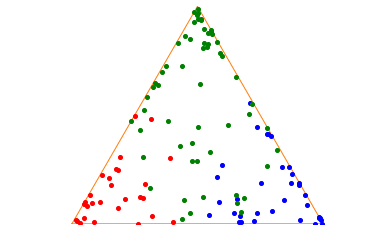

Accuracy =  0.9
    Transformation matrix: 
 [[0.22060616 0.77334348 0.63839108]
 [0.24505325 0.16827    0.25030614]
 [0.53434059 0.05838652 0.11130278]]
    Loss:  330.89660575002216




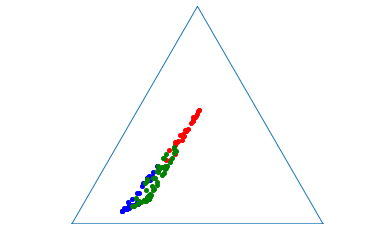

Accuracy =  0.8
    Transformation matrix: 
 [[4.33721793e-44 1.00000000e+00 3.14628335e-40]
 [5.67983372e-26 2.08019363e-56 1.00000000e+00]
 [1.00000000e+00 6.80303420e-79 4.07691278e-44]]
    Loss:  52.89265707710393




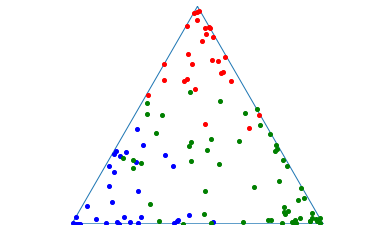

Accuracy =  0.8666666666666667
    Transformation matrix: 
 [[0.24637882 0.14273492 0.24930688]
 [0.53888085 0.05082172 0.10893278]
 [0.21474033 0.80644336 0.64176034]]
    Loss:  303.9983540306148




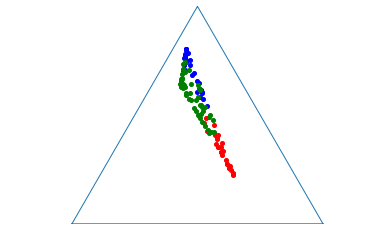

Accuracy =  0.7666666666666667
    Transformation matrix: 
 [[1.13093639e-24 2.77666176e-69 1.00000000e+00]
 [1.00000000e+00 5.68901077e-77 1.61616565e-51]
 [2.49984115e-39 1.00000000e+00 3.23337179e-51]]
    Loss:  52.89265707710392




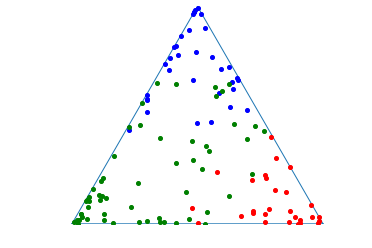

Learning rate (alpha):  0.1
 Margin (l):  0.08000000000000002
 Trade-off (mu):  0.4
Accuracy =  0.8333333333333334
    Transformation matrix: 
 [[9.99909208e-01 4.53958078e-05 4.53958078e-05]
 [4.53958078e-05 9.99909208e-01 4.53958078e-05]
 [4.53958078e-05 4.53958078e-05 9.99909208e-01]]
    Loss:  83.20398612213444




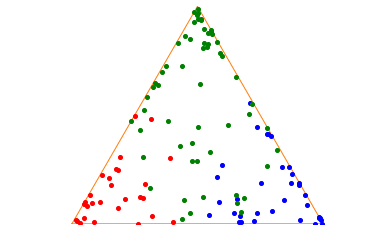

Accuracy =  0.7666666666666667
    Transformation matrix: 
 [[9.84523931e-01 3.17188188e-02 1.88827999e-01]
 [3.47684050e-03 9.67935013e-01 1.52845575e-02]
 [1.19992286e-02 3.46168125e-04 7.95887444e-01]]
    Loss:  91.27834178150579




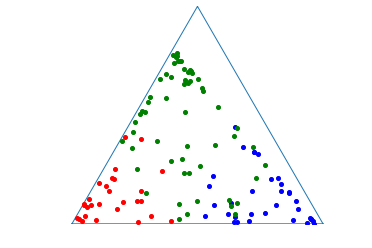

Accuracy =  0.8
    Transformation matrix: 
 [[9.99993582e-01 4.24097165e-06 2.81349358e-05]
 [6.38719093e-06 9.99986868e-01 3.12748237e-04]
 [3.07645926e-08 8.89140607e-06 9.99659117e-01]]
    Loss:  83.20452150583955




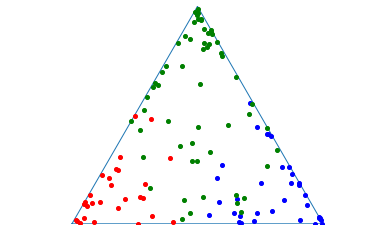

Accuracy =  0.8333333333333334
    Transformation matrix: 
 [[9.84065247e-01 3.78557487e-02 1.92034057e-01]
 [3.45470467e-03 9.61792014e-01 1.42895576e-02]
 [1.24800487e-02 3.52237686e-04 7.93676386e-01]]
    Loss:  91.79764389466702




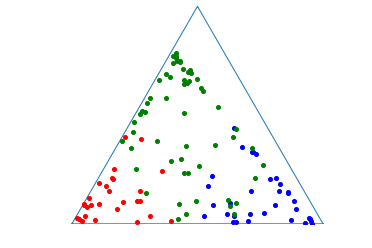

Accuracy =  0.8
    Transformation matrix: 
 [[9.99995660e-01 2.91580349e-06 2.04048724e-05]
 [4.32377949e-06 9.99989466e-01 2.93519309e-04]
 [1.62164011e-08 7.61775990e-06 9.99686076e-01]]
    Loss:  83.2041084296179




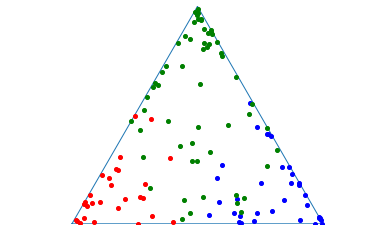

Learning rate (alpha):  0.1
 Margin (l):  0.005
 Trade-off (mu):  0.6000000000000001
Accuracy =  0.7666666666666667
    Transformation matrix: 
 [[9.99909208e-01 4.53958078e-05 4.53958078e-05]
 [4.53958078e-05 9.99909208e-01 4.53958078e-05]
 [4.53958078e-05 4.53958078e-05 9.99909208e-01]]
    Loss:  19.025406913155937




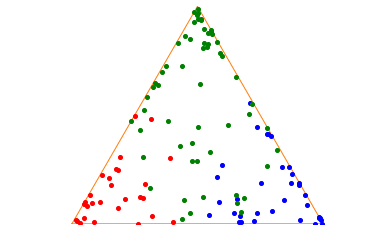

Accuracy =  0.8
    Transformation matrix: 
 [[0.00247917 0.18927571 0.4404827 ]
 [0.1532269  0.00149941 0.55343936]
 [0.84429393 0.80922488 0.00607794]]
    Loss:  17.83695656515192




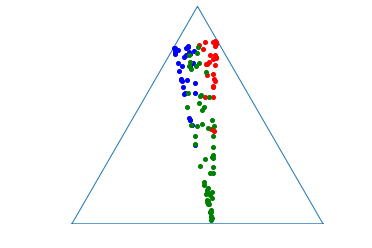

Accuracy =  0.8
    Transformation matrix: 
 [[1.60620043e-05 9.99208233e-01 6.75793866e-04]
 [9.99595921e-01 4.08569345e-04 7.57088380e-04]
 [3.88016614e-04 3.83198078e-04 9.98567118e-01]]
    Loss:  18.956626305489955




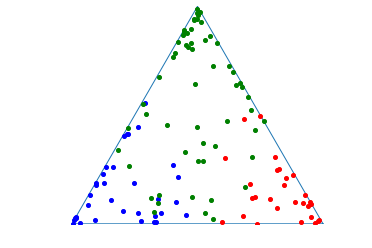

Accuracy =  0.8333333333333334
    Transformation matrix: 
 [[0.17405446 0.00187239 0.55178706]
 [0.00280081 0.15875447 0.44114481]
 [0.82314473 0.83937314 0.00706813]]
    Loss:  18.24875017670008




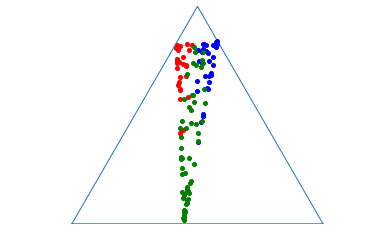

Accuracy =  0.8333333333333334
    Transformation matrix: 
 [[9.99680693e-01 1.43803011e-04 5.50444433e-04]
 [5.58812683e-06 9.99665825e-01 7.12484971e-04]
 [3.13718826e-04 1.90371879e-04 9.98737071e-01]]
    Loss:  18.977940937798365




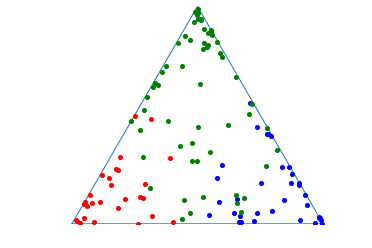

Learning rate (alpha):  0.1
 Margin (l):  0.030000000000000002
 Trade-off (mu):  0.6000000000000001
Accuracy =  0.8
    Transformation matrix: 
 [[9.99909208e-01 4.53958078e-05 4.53958078e-05]
 [4.53958078e-05 9.99909208e-01 4.53958078e-05]
 [4.53958078e-05 4.53958078e-05 9.99909208e-01]]
    Loss:  40.75878519750661




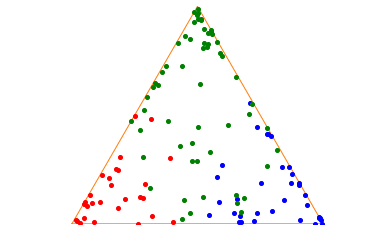

Accuracy =  0.7666666666666667
    Transformation matrix: 
 [[0.01382801 0.5618366  0.59269182]
 [0.09273528 0.02390891 0.38289175]
 [0.89343671 0.41425449 0.02441643]]
    Loss:  69.742715217921




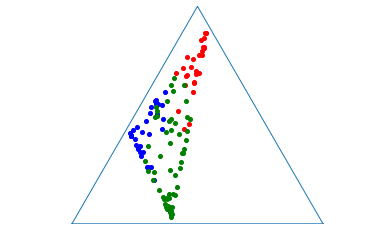

Accuracy =  0.6666666666666666
    Transformation matrix: 
 [[1.22561068e-09 9.99999998e-01 2.91032747e-10]
 [9.97470725e-01 1.32755391e-32 9.99997748e-01]
 [2.52927412e-03 1.83229741e-09 2.25192991e-06]]
    Loss:  169.98452058707977




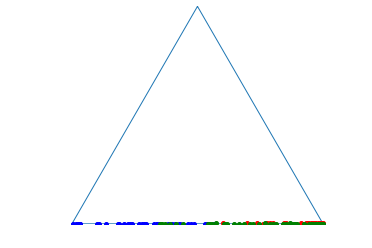

Accuracy =  0.8333333333333334
    Transformation matrix: 
 [[1.90347140e-103 9.56526434e-001 1.18582442e-008]
 [9.42914389e-093 4.34735659e-002 9.99999988e-001]
 [1.00000000e+000 2.08854735e-040 3.40507285e-282]]
    Loss:  40.51067671620841




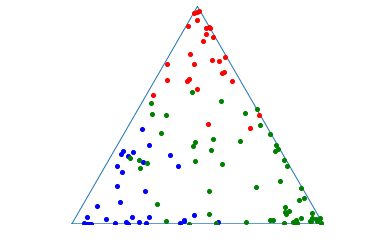

Accuracy =  0.9
    Transformation matrix: 
 [[0.48461048 0.0220908  0.25472744]
 [0.45734753 0.00719825 0.03231779]
 [0.05804199 0.97071095 0.71295477]]
    Loss:  91.35724657530704




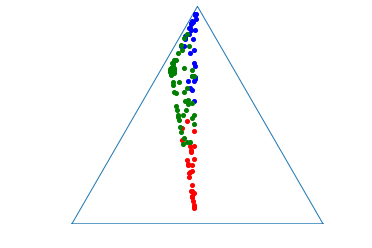

Learning rate (alpha):  0.1
 Margin (l):  0.055
 Trade-off (mu):  0.6000000000000001
Accuracy =  0.8
    Transformation matrix: 
 [[9.99909208e-01 4.53958078e-05 4.53958078e-05]
 [4.53958078e-05 9.99909208e-01 4.53958078e-05]
 [4.53958078e-05 4.53958078e-05 9.99909208e-01]]
    Loss:  73.84004006410234




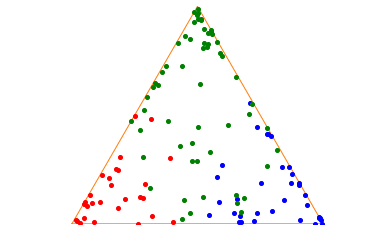

Accuracy =  0.8666666666666667
    Transformation matrix: 
 [[0.80602424 0.07084662 0.33112016]
 [0.02825643 0.92288759 0.09801959]
 [0.16571932 0.00626578 0.57086025]]
    Loss:  125.52894492866284




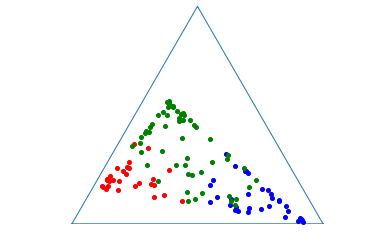

Accuracy =  0.8333333333333334
    Transformation matrix: 
 [[1.00000000e+00 2.21072261e-08 5.81612102e-23]
 [1.39778221e-17 9.99999977e-01 4.08836308e-11]
 [2.14486810e-27 8.91980921e-10 1.00000000e+00]]
    Loss:  73.83806876624324




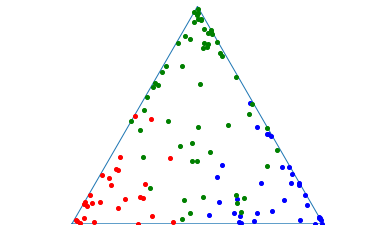

Accuracy =  0.9
    Transformation matrix: 
 [[0.80062064 0.08057844 0.33413726]
 [0.02851626 0.91309654 0.09825994]
 [0.17086311 0.00632502 0.56760281]]
    Loss:  128.8205938528433




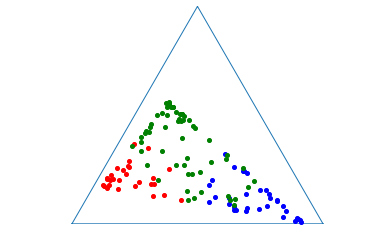

Accuracy =  0.8333333333333334
    Transformation matrix: 
 [[1.00000000e+00 1.13203066e-08 6.02774161e-24]
 [7.73284589e-19 9.99999988e-01 1.65264428e-11]
 [1.97757768e-28 3.87594940e-10 1.00000000e+00]]
    Loss:  73.83806867913697




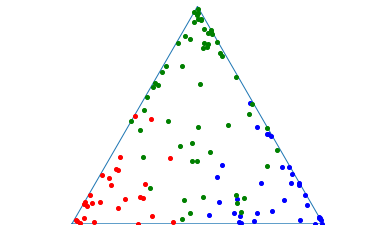

Learning rate (alpha):  0.1
 Margin (l):  0.08000000000000002
 Trade-off (mu):  0.6000000000000001
Accuracy =  0.7666666666666667
    Transformation matrix: 
 [[9.99909208e-01 4.53958078e-05 4.53958078e-05]
 [4.53958078e-05 9.99909208e-01 4.53958078e-05]
 [4.53958078e-05 4.53958078e-05 9.99909208e-01]]
    Loss:  119.31049911939498




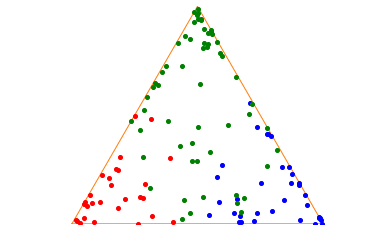

Accuracy =  0.8
    Transformation matrix: 
 [[9.99920336e-01 4.62176401e-05 4.85550053e-03]
 [6.28359385e-06 9.99953558e-01 1.34822989e-04]
 [7.33804256e-05 2.24651188e-07 9.95009676e-01]]
    Loss:  119.42250114701214




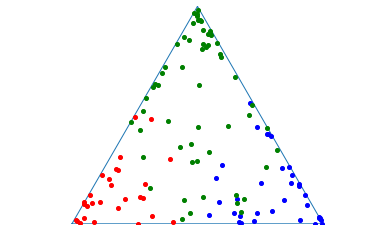

Accuracy =  0.8333333333333334
    Transformation matrix: 
 [[9.99930496e-01 1.48817121e-05 2.56318234e-03]
 [6.54432538e-06 9.99984902e-01 1.30888219e-04]
 [6.29601509e-05 2.16437682e-07 9.97305929e-01]]
    Loss:  119.36470643947627




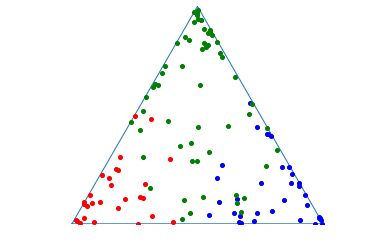

Accuracy =  0.7666666666666667
    Transformation matrix: 
 [[9.99928697e-01 2.71179390e-05 3.35302515e-03]
 [6.33662829e-06 9.99972662e-01 1.33182178e-04]
 [6.49661389e-05 2.20075714e-07 9.96513793e-01]]
    Loss:  119.38424455985917




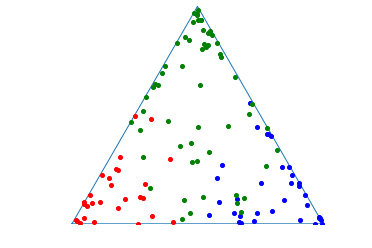

Accuracy =  0.8333333333333334
    Transformation matrix: 
 [[9.99930519e-01 2.19416668e-05 3.01832285e-03]
 [6.27697577e-06 9.99977843e-01 1.31476364e-04]
 [6.32039576e-05 2.15792647e-07 9.96850201e-01]]
    Loss:  119.37583459794486




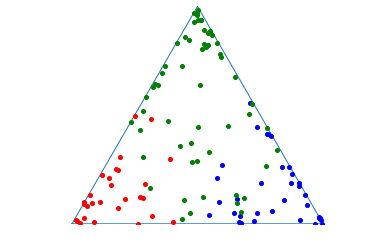

Learning rate (alpha):  0.1
 Margin (l):  0.005
 Trade-off (mu):  0.8
Accuracy =  0.7666666666666667
    Transformation matrix: 
 [[9.99909208e-01 4.53958078e-05 4.53958078e-05]
 [4.53958078e-05 9.99909208e-01 4.53958078e-05]
 [4.53958078e-05 4.53958078e-05 9.99909208e-01]]
    Loss:  21.70355584167011




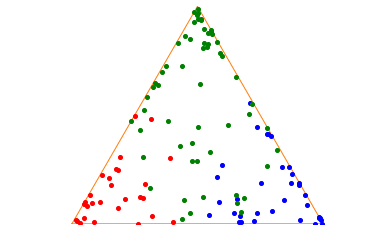

Accuracy =  0.8
    Transformation matrix: 
 [[0.00272781 0.05185489 0.39014268]
 [0.06427692 0.00208358 0.59920927]
 [0.93299527 0.94606154 0.01064805]]
    Loss:  47.06092708188378




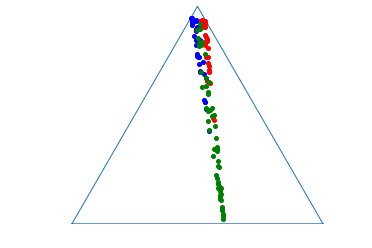

Accuracy =  0.8333333333333334
    Transformation matrix: 
 [[5.68642191e-32 1.00000000e+00 1.52193694e-06]
 [1.00000000e+00 4.57088037e-26 1.25354041e-06]
 [5.65836335e-17 9.13063403e-21 9.99997225e-01]]
    Loss:  21.710750693548423




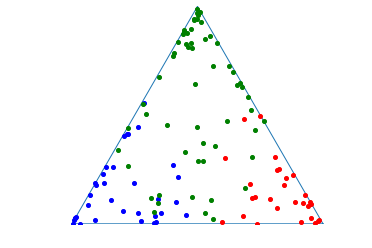

Accuracy =  0.7666666666666667
    Transformation matrix: 
 [[0.0635251  0.00205432 0.59947695]
 [0.00269258 0.05378478 0.38986467]
 [0.93378233 0.94416091 0.01065838]]
    Loss:  46.74638999911337




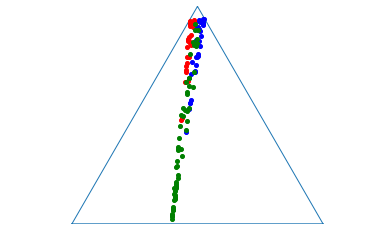

Accuracy =  0.8666666666666667
    Transformation matrix: 
 [[1.00000000e+00 1.18484027e-25 1.33541684e-06]
 [6.99011846e-32 1.00000000e+00 1.49664725e-06]
 [7.03663634e-17 1.66717146e-20 9.99997168e-01]]
    Loss:  21.71074944661513




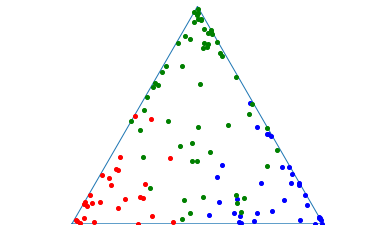

Learning rate (alpha):  0.1
 Margin (l):  0.030000000000000002
 Trade-off (mu):  0.8
Accuracy =  0.7666666666666667
    Transformation matrix: 
 [[9.99909208e-01 4.53958078e-05 4.53958078e-05]
 [4.53958078e-05 9.99909208e-01 4.53958078e-05]
 [4.53958078e-05 4.53958078e-05 9.99909208e-01]]
    Loss:  50.68139355413774




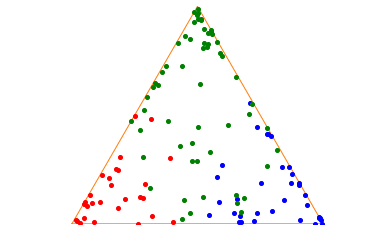

Accuracy =  0.7666666666666667
    Transformation matrix: 
 [[0.02531243 0.31955258 0.57143491]
 [0.03086863 0.1207983  0.3615178 ]
 [0.94381893 0.55964912 0.06704729]]
    Loss:  231.0828349565089




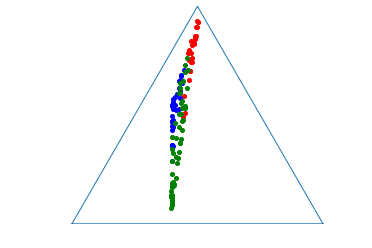

Accuracy =  0.6666666666666666
    Transformation matrix: 
 [[1.26315662e-35 1.00000000e+00 1.30557503e-23]
 [9.99969022e-01 6.82262811e-59 1.00000000e+00]
 [3.09780894e-05 7.08595776e-27 1.60352430e-21]]
    Loss:  228.35831638633044




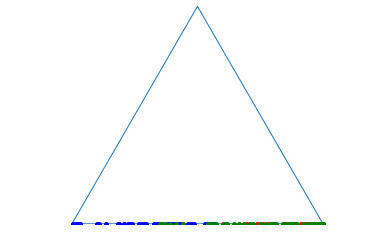

Accuracy =  0.8
    Transformation matrix: 
 [[1.52020334e-140 9.94709523e-001 4.20968216e-012]
 [2.34038700e-124 5.29047748e-003 1.00000000e+000]
 [1.00000000e+000 5.41170842e-055 0.00000000e+000]]
    Loss:  50.62946871851887




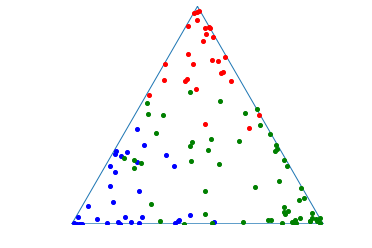

Accuracy =  0.8666666666666667
    Transformation matrix: 
 [[0.05356425 0.1666111  0.35307576]
 [0.90572832 0.3516696  0.06896108]
 [0.04070744 0.4817193  0.57796316]]
    Loss:  201.16534167373237




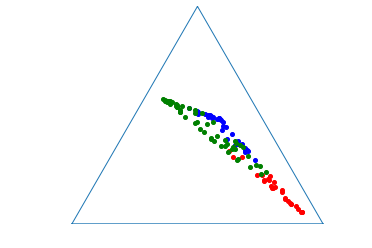

Learning rate (alpha):  0.1
 Margin (l):  0.055
 Trade-off (mu):  0.8
Accuracy =  0.8
    Transformation matrix: 
 [[9.99909208e-01 4.53958078e-05 4.53958078e-05]
 [4.53958078e-05 9.99909208e-01 4.53958078e-05]
 [4.53958078e-05 4.53958078e-05 9.99909208e-01]]
    Loss:  94.78973337626527




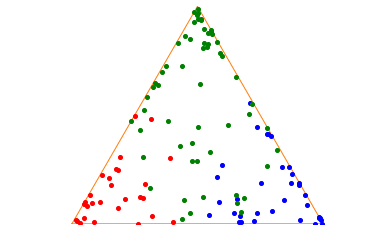

Accuracy =  0.8666666666666667
    Transformation matrix: 
 [[9.81779611e-01 1.28044466e-03 5.47305560e-02]
 [1.08619952e-03 9.98586898e-01 1.22320632e-02]
 [1.71341897e-02 1.32657814e-04 9.33037381e-01]]
    Loss:  96.55931502616826




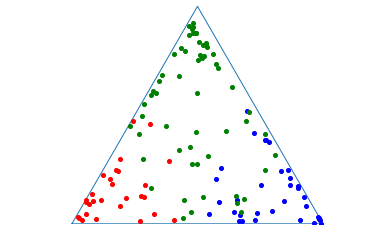

Accuracy =  0.8666666666666667
    Transformation matrix: 
 [[9.99505169e-01 6.78846617e-05 3.90298612e-03]
 [3.29309233e-04 9.99912667e-01 2.03528596e-03]
 [1.65521958e-04 1.94481818e-05 9.94061728e-01]]
    Loss:  94.87126209382




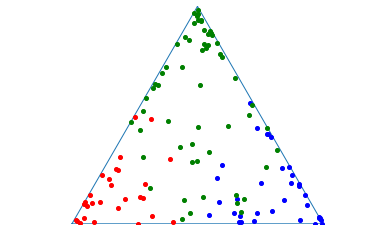

Accuracy =  0.8333333333333334
    Transformation matrix: 
 [[9.84432591e-01 7.87324064e-04 4.44095601e-02]
 [9.60989762e-04 9.99115316e-01 9.42144234e-03]
 [1.46064192e-02 9.73594819e-05 9.46168998e-01]]
    Loss:  96.1397178261328




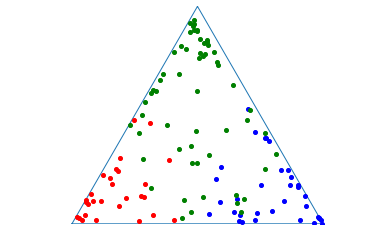

Accuracy =  0.7666666666666667
    Transformation matrix: 
 [[9.99385097e-01 7.25352795e-05 6.22702585e-03]
 [3.54823844e-04 9.99900457e-01 3.05962706e-03]
 [2.60079487e-04 2.70081225e-05 9.90713347e-01]]
    Loss:  94.91716232684958




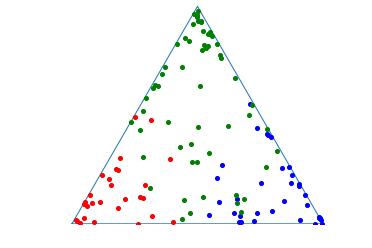

Learning rate (alpha):  0.1
 Margin (l):  0.08000000000000002
 Trade-off (mu):  0.8
Accuracy =  0.8666666666666667
    Transformation matrix: 
 [[9.99909208e-01 4.53958078e-05 4.53958078e-05]
 [4.53958078e-05 9.99909208e-01 4.53958078e-05]
 [4.53958078e-05 4.53958078e-05 9.99909208e-01]]
    Loss:  155.41701211665594




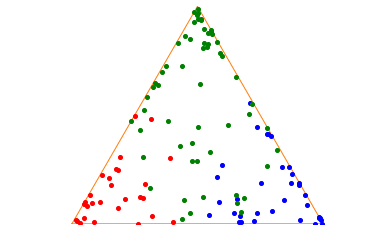

Accuracy =  0.8
    Transformation matrix: 
 [[9.99999547e-01 6.51906091e-08 1.00358616e-04]
 [1.11821863e-08 9.99999935e-01 9.55934358e-07]
 [4.41878025e-07 1.41129198e-10 9.99898685e-01]]
    Loss:  155.40100321762995




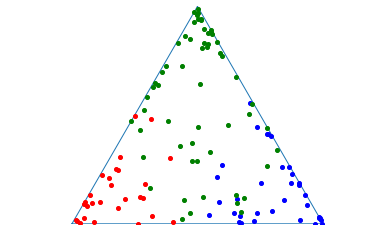

Accuracy =  0.8
    Transformation matrix: 
 [[9.99999507e-01 7.03561377e-08 1.02493404e-04]
 [1.12532830e-08 9.99999929e-01 9.66258327e-07]
 [4.82059628e-07 1.59797190e-10 9.99896540e-01]]
    Loss:  155.40109438400856




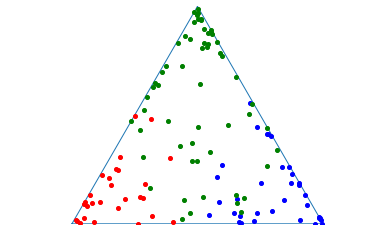

Converged...


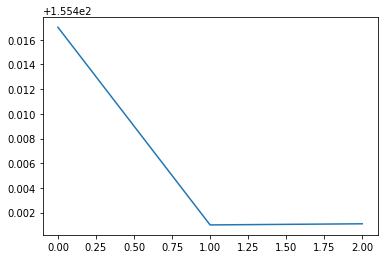

In [134]:
ITERATIONS = 5
lrange = np.arange(0.005, 0.1, 0.025)
murange = np.arange(0.2, 1, 0.2)
alpha = 0.1
accuracyTable = np.zeros((len(lrange), len(murange)))

j = 0
k = 0
for mu in murange:
    for l in lrange:
        lossList = []
        print("Learning rate (alpha): ", alpha)
        print(" Margin (l): ", l)
        print(" Trade-off (mu): ", mu)
        
        ## Initialise L matrix
        L = 10*np.eye(D, dtype=float) + 0.01*D
        L = softmax(L, axis = 0)
        lossOld = -1000000
        
        for i in range(ITERATIONS):
            Gt, lossNew = gradient_and_loss_function(X_train, y_train, L)
            lossList.append(lossNew)

            n_right = 0
            prediction = []
            for i in range(len(X_test)):
                prediction.append(random.choice(calc_mode(knnClassifier.knn(X_test[i], X_train, y_train, L, 12))))
            accuracy = np.mean(np.array(prediction) == y_test.astype(str))
            print("Accuracy = ", accuracy)
            
            if(accuracy > accuracyTable[j, k]):
                accuracyTable[j, k] = accuracy

            print("    Transformation matrix: \n", L)
            print("    Loss: ", lossNew)
            print("\n")
            plot_simplex_3d( (L @ X_train.T).T, y_train, False, -1)

            if(abs(lossNew - lossOld) < 1e-4):
                print("Converged...")
                break
            lossOld = lossNew

            ## Update the transformation matrix using the gradient.
            update_step(Gt)

        plt.plot(lossList)
    j += 1
k += 1
    


Learning rate (alpha):  0.1
 Margin (l):  0.005
 Trade-off (mu):  0.2


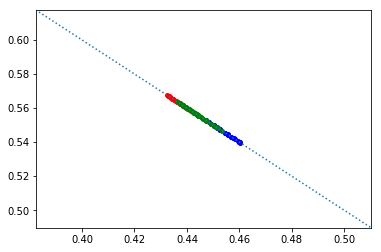

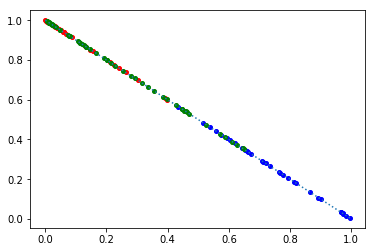

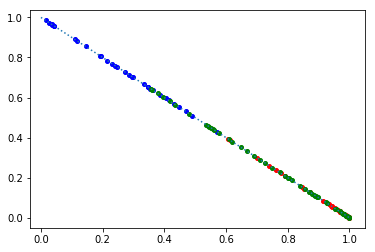

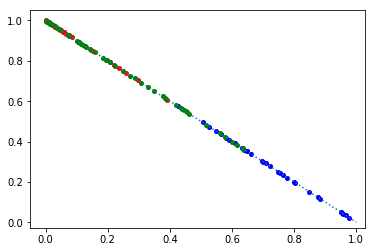

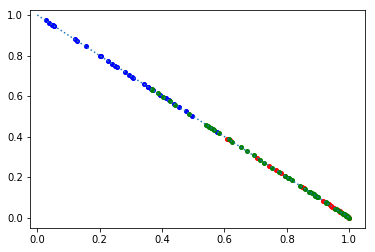

[0.8, 0.7666666666666667, 0.7, 0.7, 0.6666666666666666]


In [238]:
lossList = []
ITERATIONS = 5
print("Learning rate (alpha): ", alpha)
print(" Margin (l): ", l)
print(" Trade-off (mu): ", mu)
L = np.random.rand(2, 3)
L = softmax(L, axis = 0)
l = 0.005
mu = 0.2
accList = []

for i in range(ITERATIONS):
    Gt, lossNew = gradient_and_loss_function(X_train, y_train, L)
    n_right = 0
    prediction = []
    for i in range(len(X_test)):
        prediction.append(random.choice(calc_mode(knnClassifier.knn(X_test[i], X_train, y_train, L, 12))))
    accuracy = np.mean(np.array(prediction) == y_test.astype(str))
    accList.append(accuracy)
    
    plot_simplex_2d( (L @ X_train.T).T, y_train)

    ## Update the transformation matrix using the gradient.
    update_step(Gt)
print(accList)

In [212]:
L = [[1.30919014e-03, 8.09658054e-01, 5.42191444e-01],
     [5.56680056e-01, 2.49309742e-04, 4.55896321e-01],
     [4.42010754e-01, 1.90092636e-01, 1.91223482e-03]] ## Tranformation matrix for mu = 0.2, l = 0.005.

krange = np.arange(2, 40, 2)
accLMNN_Mean = []
accKNN_Mean = []
for k in krange:
    accListLMNNkNN = []
    accListkNN = []

    ## Has to be repeated since random choice is used for tie-breaker
    for i in range(5):
        cv = KFold(n_splits = 150, random_state=42, shuffle=False)
        for train_index, test_index in cv.split(pts):
            X_train = pts[train_index, :]
            X_test = pts[test_index, :]
            y_train = label[train_index]
            y_test = label[test_index]

            ## Predict using identity matrix.
            prediction = []
            for i in range(len(X_test)):
                prediction.append(random.choice(calc_mode(knnClassifier.knn(X_test[i], X_train, y_train, np.eye(D), k))))
            accuracy = np.mean(np.array(prediction) == y_test.astype(str))
            accListkNN.append(accuracy)

            ## Predict using L.
            prediction = []
            for i in range(len(X_test)):
                prediction.append(random.choice(calc_mode(knnClassifier.knn(X_test[i], X_train, y_train, L, k))))
            accuracy = np.mean(np.array(prediction) == y_test.astype(str))
            accListLMNNkNN.append(accuracy)
    
    accLMNN_Mean.append(np.mean(accListLMNNkNN))
    accKNN_Mean.append(np.mean(accListkNN))

Text(0, 0.5, 'Test Classification Accuracy')

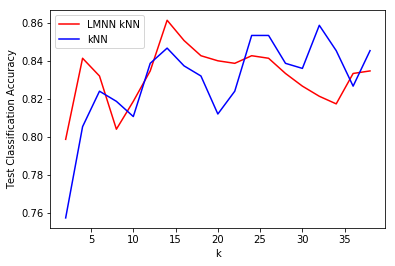

In [221]:
line1, = plt.plot(krange, accLMNN_Mean, c = 'r', label = 'LMNN kNN')
line2, = plt.plot(krange, accKNN_Mean, c = 'b', label = 'kNN')
plt.legend(loc='upper left')
plt.xlabel('k')
plt.ylabel('Test Classification Accuracy')

## Dataset - IRIS

Shape of IRIS dataset: (150,4)

In [11]:
iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=0)

# Normalize data
X_train = X_train / np.sum(X_train, axis = 1)[:,None]
X_test = X_test / np.sum(X_test, axis = 1)[:,None]

In [115]:
mu = 0.5
K = 3
_, D = np.shape(X_train)
L = np.eye(D, dtype=float)
alpha = 0.001

In [142]:
TN_lookup_table, TN_distance_table = find_target_neighbors(X_train, y_train, L)
l = np.median(TN_distance_table)

## Dataset - Fruits

In [ ]:
X_train, y_train = Model.get_data('data.db')
X_test, y_test = Model.get_data('data_test.db')
s_score = sk_metrics.silhouette_score(X_train.T, y_train, metric='euclidean')

print("Shape of trained embeddings is: {}".format(np.shape(X_train)))
print("Shape of trained labels is: {} ".format(np.shape(y_train)))
print("Shape of test embeddings is: {}".format(np.shape(X_test)))
print("Shape of test labels is: {} ".format(np.shape(y_test)))
print("Silhouette Score of data is: {}".format(s_score))

In [21]:
#By increasing the number of components we deal with the check-function issue (To be fixed)
pca = sk_decomp.PCA(n_components=4)
pca.fit(X_train.T)
X_train = pca.transform(X_train.T)
X_train = abs(X_train / np.linalg.norm(X_train))

X_test = pca.transform(X_test.T)
X_test = abs(X_test / np.linalg.norm(X_test))

s_score = sk_metrics.silhouette_score(X_train, y_train, metric='euclidean')
print("Explained variance of low dimensional data is: {}".format(sum(pca.explained_variance_ratio_)))
print("Silhouette Score of data is: {}".format(s_score))

Explained variance of low dimensional data is: 0.5692216530442238
Silhouette Score of data is: 0.6079602241516113


In [158]:
#It's very important to set the margin very low as the data points are quite densly packed
mu = 0.7
K = 1
alpha = 0.001
_, D = np.shape(X_train)
L = np.eye(D, dtype=float)

In [159]:
TN_lookup_table, TN_distance_table = find_target_neighbors(X_train, y_train, L)
l = 0.0001

### Histograms using the initial linear transformation matrix L

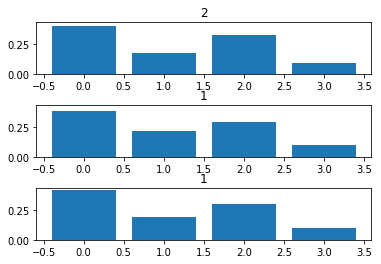

In [14]:
new_X = (L @ X_train.T).T

plot_items = new_X[10:25:5,:]
plot_labels = y_train[10:25:5]
Plots.plot_some_data(plot_items, plot_labels)

## Run

0
0
1
2
[[0.5746992  0.21291713 0.21238368]
 [0.21269341 0.57429796 0.21300863]
 [0.21299614 0.21258301 0.57442085]]
22.359045779370046


1
0
1
2
[[0.41792722 0.29111982 0.29095296]
 [0.29106648 0.41778624 0.29114728]
 [0.29114455 0.29102748 0.41782797]]
2.6197458097185993


2
0
1
2
[[0.36208522 0.31898547 0.31892931]
 [0.31897003 0.36203744 0.31899252]
 [0.31899213 0.31895484 0.36205303]]
0.47036410504917114


3
0
1
2
[[0.34297972 0.32851981 0.32850046]
 [0.32851493 0.3429638  0.32852127]
 [0.32852129 0.32850895 0.34296976]]
0.6575847103344845


4
0
1
2
[[0.33655467 0.33172602 0.33171931]
 [0.33172442 0.3365494  0.33172618]
 [0.33172623 0.3317221  0.33655166]]
6.979783175309166




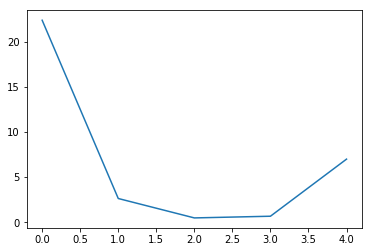

In [160]:
ITERATIONS = 5
lossList = []

for i in range(ITERATIONS):
    print(i)
    #Gt = (1 - mu) * Pull(X_train, L) + mu * Push(X_train, L, y_train)
    #loss = loss_function(X_train, y_train, L)
    Gt, loss = gradient_and_loss_function(X_train, y_train, L)
    lossList.append(loss)
    update_step(Gt)
    print(L)
    print(loss)
    print("\n")
    

plt.plot(lossList, '-')
plt.show()

As expected, the loss follows an exponentially decreasing function. Having as component the loss from pushing the impostors and pulling the target neighbors, this means that the target neighbors are pulled closer and the impostors pushed away.

### Plot of the linear trasformation matrix L

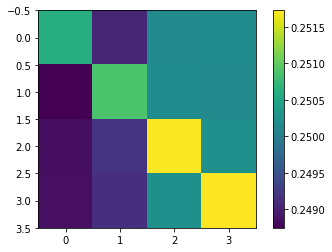

In [27]:
Plots.plot_kernel(L)

### Histograms using the updated linear transformation matrix L

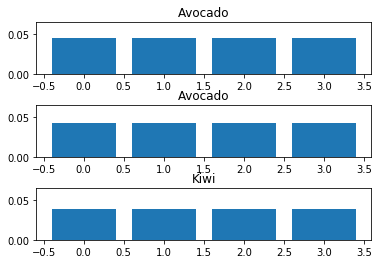

array([[0.04477734, 0.04484091, 0.04481971, 0.04480715],
       [0.04307202, 0.04313778, 0.0431152 , 0.04310978],
       [0.03802428, 0.0381872 , 0.03807529, 0.03809051]])

In [28]:
#new_X = X_train
new_X = (L @ X_train.T).T
plot_items = new_X[10:20:4,:]
plot_labels = y_train[10:20:4]
Plots.plot_some_data(plot_items, plot_labels)
new_X[10:20:4,:]

## Testing

Further, in order to check the increase in accuracy, we have implemented a knnClassifier

Confusion matrix, without normalization
[[6 0 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 2 2]]


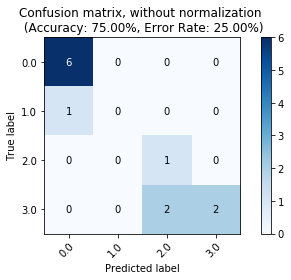

In [296]:
prediction = []

for i in range(len(X_test)):
    prediction.append(random.choice(calc_mode(knnClassifier.knn(X_test[i], X_train, y_train, L, 10))))
confusion_matrix = plots.plot_confusion_matrix(y_test.astype(str), prediction, normalize=False)

Confusion matrix, without normalization
[[5 0 1 0]
 [1 0 0 0]
 [0 0 0 0]
 [0 1 0 0]]


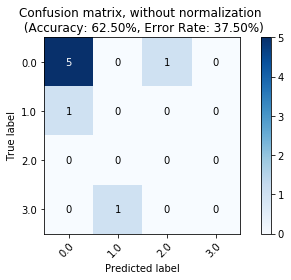

In [406]:
prediction = []

for i in range(len(X_test)):
    prediction.append(random.choice(calc_mode(knnClassifier.knn(X_test[i], X_train, y_train, np.eye(D), 10))))
confusion_matrix = plots.plot_confusion_matrix(y_test.astype(str), prediction, normalize=False)

In [113]:
knn_accuracy(X_test, X_train, y_train, y_test, L, 12)

0.8

In [111]:
def knn_accuracy(Xtest, Xtrain, ytrain, ytest, L, K):
    N, D = Xtest.shape
    n_correct = 0
    for i in range(N):
        xi = X_test[i,:]
        yi = ytrain[i]
        
        # Find distance from xi to all other points
        distances = distance(xi, X_train, L)
        indicies  = np.argsort(distances)
        knearest  = indicies[0:K]
        if(mode(y_train[knearest]) == y_test[i]):
            n_correct += 1
    return n_correct / N

In [64]:
arrtest = []
arrtest.append(1)
arrtest.append(1)
arrtest.append(5)

In [65]:
max(set(arrtest))

5

In [94]:
from statistics import mode
from collections import Counter